# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Devin Novansyah
- **Email:** devinnovansyah1611@gmail.com
- **ID Dicoding:** devin_nv

## Menentukan Pertanyaan Bisnis

- Pertanyaan 1 : Produk kategori apa yang paling diminati oleh pelanggan (volume penjualan tertinggi)?
- Pertanyaan 2 : Bagaimana tren jumlah pesanan di platform E-commerce dalam rentang waktu yang tersedia?

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

### Gathering Data

In [2]:
# Memuat semua dataset yang dibutuhkan
orders_df = pd.read_csv("orders_dataset.csv")
order_items_df = pd.read_csv("order_items_dataset.csv")
products_df = pd.read_csv("products_dataset.csv")
category_translation_df = pd.read_csv("product_category_name_translation.csv")

# Menampilkan 5 baris pertama dari tabel utama (orders) untuk memastikan data termuat
display(orders_df.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


**Insight:**
Seluruh dataset yang diperlukan untuk menjawab pertanyaan bisnis (Orders, Order Items, Products, dan Category Translation) berhasil dimuat. Dataset utama yang akan dianalisis berpusat pada tabel orders dan order_items.

### Assessing Data

In [3]:
print("=== Info Orders DataFrame ===")
orders_df.info()
print("\n=== Missing Values di Orders ===")
print(orders_df.isna().sum())
print("\n=== Duplikasi di Orders ===")
print("Jumlah duplikasi:", orders_df.duplicated().sum())

print("\n" + "="*30 + "\n")

print("=== Info Products DataFrame ===")
products_df.info()
print("\n=== Missing Values di Products ===")
print(products_df.isna().sum())
print("\n=== Duplikasi di Products ===")
print("Jumlah duplikasi:", products_df.duplicated().sum())

=== Info Orders DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB

=== Missing Values di Orders ===
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_de

**Insight:**
- Tipe Data: Kolom yang berisi tanggal pada orders_df (seperti order_purchase_timestamp) masih bertipe object (string), harus diubah ke datetime untuk analisis time series.

- Missing Values: Terdapat data kosong pada kolom order_approved_at, order_delivered_carrier_date, dan order_delivered_customer_date. Ini wajar jika pesanan dibatalkan atau belum dikirim, namun perlu diperhatikan saat filtering. Pada products_df, terdapat beberapa produk yang tidak memiliki nama kategori (product_category_name).

- Duplikasi: Tidak ditemukan data duplikat pada kedua dataframe utama (jumlah duplikasi = 0), sehingga data cukup bersih dari redundansi.

### Cleaning Data

In [4]:
# 1. Memperbaiki Tipe Data (Datetime)
datetime_columns = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]

for column in datetime_columns:
  orders_df[column] = pd.to_datetime(orders_df[column])

# 2. Menggabungkan Data (Merge) untuk memudahkan analisis
# Menggabungkan order_items dengan products untuk mendapat kategori
items_products_df = pd.merge(
    left=order_items_df,
    right=products_df,
    how="left",
    left_on="product_id",
    right_on="product_id"
)

# Menggabungkan dengan terjemahan kategori agar nama kategori dalam Bahasa Inggris
all_data_df = pd.merge(
    left=items_products_df,
    right=category_translation_df,
    how="left",
    left_on="product_category_name",
    right_on="product_category_name"
)

# Menggabungkan data lengkap produk dengan data order utama
all_data_df = pd.merge(
    left=all_data_df,
    right=orders_df[['order_id', 'order_purchase_timestamp']],
    how="left",
    left_on="order_id",
    right_on="order_id"
)

# 3. Menangani Missing Values pada Kategori (Opsional tapi rapi)
# Mengisi nama kategori yang kosong dengan 'unknown' atau 'others'
all_data_df['product_category_name_english'].fillna('unknown', inplace=True)

display(all_data_df.head())
display(all_data_df.info())

/tmp/ipython-input-1989335851.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data_df['product_category_name_english'].fillna('unknown', inplace=True)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools,2017-02-04 13:57:51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   seller_id                      112650 non-null  object        
 4   shipping_limit_date            112650 non-null  object        
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   product_category_name          111047 non-null  object        
 8   product_name_lenght            111047 non-null  float64       
 9   product_description_lenght     111047 non-null  float64       
 10  product_photos_qty             111047 non-null  float64       
 11  

None

**Insight:**
- Kolom tanggal pada orders_df telah berhasil diubah menjadi tipe datetime.

- Telah dilakukan penggabungan (merge) antara tabel order_items, products, category_translation, dan mengambil timestamp dari orders. Hasilnya adalah tabel all_data_df yang komprehensif.

- Missing values pada nama kategori bahasa Inggris telah diisi dengan "unknown" untuk mencegah error saat visualisasi. Data siap digunakan untuk Exploratory Data Analysis (EDA).

## Exploratory Data Analysis (EDA)

### Explore ...

In [5]:
# === Eksplorasi Pertanyaan 1: Kategori Produk Terlaris ===
# Menghitung jumlah order item per kategori
category_counts = all_data_df['product_category_name_english'].value_counts().reset_index()
category_counts.columns = ['category', 'order_count']

print("Top 10 Kategori Produk:")
print(category_counts.head(10))

# === Eksplorasi Pertanyaan 2: Tren Bulanan ===
# Membuat kolom bulan-tahun (YYYY-MM)
all_data_df['month_year'] = all_data_df['order_purchase_timestamp'].dt.to_period('M')

# Menghitung jumlah order per bulan
monthly_orders = all_data_df.groupby('month_year')['order_id'].count()

print("\nTren Order Bulanan (5 data teratas):")
print(monthly_orders.head())

Top 10 Kategori Produk:
                category  order_count
0         bed_bath_table        11115
1          health_beauty         9670
2         sports_leisure         8641
3        furniture_decor         8334
4  computers_accessories         7827
5             housewares         6964
6          watches_gifts         5991
7              telephony         4545
8           garden_tools         4347
9                   auto         4235

Tren Order Bulanan (5 data teratas):
month_year
2016-09       6
2016-10     363
2016-12       1
2017-01     955
2017-02    1951
Freq: M, Name: order_id, dtype: int64


**Insight:**
- Dari hasil perhitungan sederhana, kategori bed_bath_table dan health_beauty terlihat mendominasi jumlah pesanan.

- Data time series menunjukkan adanya fluktuasi penjualan, yang akan lebih jelas terlihat saat divisualisasikan.

## Visualization & Explanatory Analysis



### Pertanyaan 1:

/tmp/ipython-input-3952546302.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


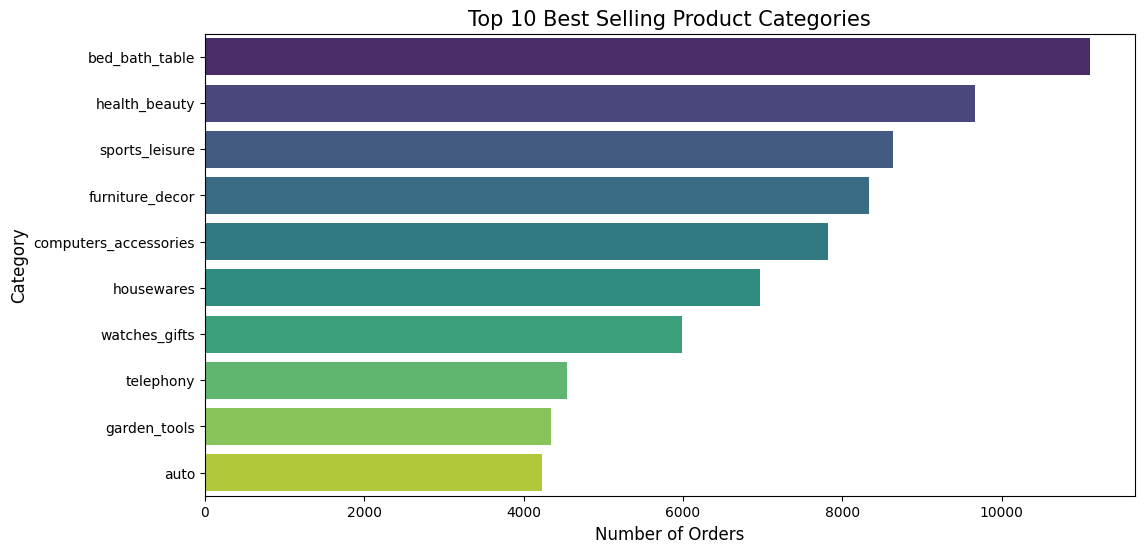

In [10]:
# Kategori produk apa yang memiliki volume penjualan tertinggi?
# Filter top 10 categories
top_10_categories = category_counts.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='order_count',
    y='category',
    data=top_10_categories,
    palette='viridis'
)
plt.title('Top 10 Best Selling Product Categories', fontsize=15)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

### Pertanyaan 2:

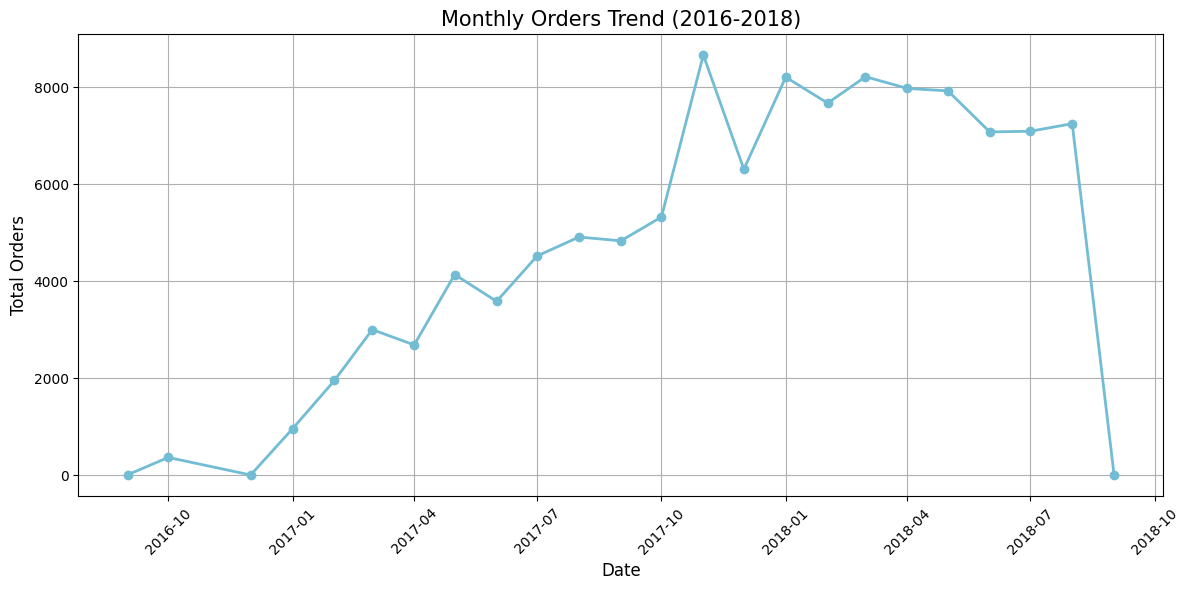

In [9]:
# Bagaimana tren jumlah pesanan per bulan?
# Ubah index period kembali ke timestamp agar bisa diplot
monthly_orders_timestamp = monthly_orders.index.to_timestamp()

plt.figure(figsize=(14, 6))
plt.plot(
    monthly_orders_timestamp,
    monthly_orders.values,
    marker='o',
    linewidth=2,
    color="#72BCD4"
)
plt.title('Monthly Orders Trend (2016-2018)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Orders', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Insight:**
- Insight Visualisasi 1: Grafik batang di atas memperlihatkan bahwa Bed Bath Table adalah kategori paling populer dengan selisih yang cukup signifikan dibandingkan kategori lainnya. Kategori yang berkaitan dengan gaya hidup (Health Beauty, Sports Leisure) dan dekorasi rumah (Furniture Decor) juga mendominasi 5 besar, menunjukkan bahwa pelanggan cenderung menggunakan platform ini untuk kebutuhan rumah tangga dan pribadi.
- Insight Visualisasi 2: Grafik garis menunjukkan tren pertumbuhan positif dari tahun 2016 hingga 2018. Lonjakan pesanan paling tajam terjadi pada bulan November 2017, yang kemungkinan besar didorong oleh periode promosi besar seperti Black Friday. Setelah puncak tersebut, volume pesanan tetap stabil di angka yang tinggi dibandingkan tahun-tahun sebelumnya.

## Conclusion

- Conclution pertanyaan 1: Berdasarkan analisis visualisasi data, kategori produk Bed Bath Table (Perlengkapan Kamar & Mandi) menempati urutan pertama sebagai produk paling laris, diikuti oleh Health Beauty dan Sports Leisure. Hal ini mengindikasikan preferensi konsumen yang kuat terhadap produk kebutuhan rumah tangga dan kesehatan di platform ini.

- Conclution pertanyaan 2: Tren penjualan menunjukkan pola yang menarik. Meskipun sempat rendah di awal (2016), terjadi kenaikan yang konsisten sepanjang tahun 2017, dengan puncak tertinggi terjadi pada bulan November 2017 (kemungkinan besar dipengaruhi oleh event Black Friday). Setelah itu, tren cenderung stabil di angka yang tinggi hingga pertengahan 2018.

In [11]:
# Simpan data yang sudah dibersihkan untuk digunakan di Dashboard
all_data_df.to_csv("all_data.csv", index=False)